# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ
# 4228

In [2]:
import numpy as np
import cupy as cp
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tqdm import tqdm


Loading the data

In [3]:

# Load the dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()


Extracting only 'cat' and 'dog' lables

In [4]:
# Define the classes
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [5]:
def random_crop_with_padding(images, crop_size=(32, 32), padding=4):

    # Ensure images are CuPy arrays
    images = cp.asarray(images)

    # Get image dimensions
    size, height, width, channels = images.shape

    # Create a padded image array
    padded_height = height + 2 * padding
    padded_width = width + 2 * padding
    padded_images = cp.zeros((size, padded_height, padded_width, channels), dtype=images.dtype)

    # Copy original images into the center of the padded images
    padded_images[:, padding:padding+height, padding:padding+width, :] = images

    # Initialize an array to store cropped images
    cropped_images = cp.empty((size, crop_size[0], crop_size[1], channels), dtype=images.dtype)

    # Randomly crop each image
    for i in range(size):
        h_start = np.random.randint(0, 2 * padding + 1)
        w_start = np.random.randint(0, 2 * padding + 1)
        cropped_images[i] = padded_images[i, h_start:h_start+crop_size[0], w_start:w_start+crop_size[1], :]
    
    return cropped_images


transforming to cupy arrays

In [6]:

x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)

# Shuffle the data randomly
indices = cp.arange(x_train.shape[0])
cp.random.shuffle(indices)

# Apply shuffled indices to x_train and y_train
x_train = x_train[indices]
y_train = y_train[indices]




# SVM functions

In [7]:


def compute_loss(w, X, y, b, reg_lambda):
    dot_products = cp.dot(X, w) + b  
    distances = 1 - y * dot_products
    distances = cp.maximum(0, distances)  # Hinge loss
    hinge_loss = cp.mean(distances)
    reg_loss = 0.5 * reg_lambda * cp.sum(w ** 2)  
    total_loss = hinge_loss + reg_loss
    return total_loss




def compute_gradient(w, X, y, b, reg_lambda):
    n_samples = X.shape[0]
    dot_products = cp.dot(X, w) + b
    distances = 1 - y * dot_products
    misclassified = distances > 0  # Boolean array for misclassified samples
    
    # Gradient for weights
    grad_w = -cp.dot((misclassified * y).T, X) / n_samples + reg_lambda * w
    
    # Gradient for bias
    grad_b = -cp.mean(misclassified * y)  # Mean gradient for bias
    
    return grad_w, grad_b





In [8]:
def up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr):
    if epoch <= ramp_up_epochs:
        # Linear ramp-up
        lr = min_lr + (max_lr - min_lr) * (epoch / ramp_up_epochs)
    else:
        # Linear ramp-down
        lr = max_lr - (max_lr - min_lr) * ((epoch - ramp_up_epochs) / (total_epochs - ramp_up_epochs))
    return lr


In [ ]:
def train_svm(
    X_train, y_train, X_test, y_test,
    min_lr, max_lr, ramp_up_epochs, total_epochs,
    reg_lambda
):
    n_samples, n_features = X_train.shape
    
    # Initialize weights and bias
    w = cp.zeros(n_features)
    b = cp.zeros(1)
    
    train_losses = []
    test_losses = []
    lr_history = []
    
    pbar = tqdm(range(1, total_epochs + 1), desc='Training Progress')
    for epoch in pbar:
        # learning rate using the scheduler
        lr = up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr)
        lr_history.append(lr)
        
        # Compute gradients
        grad_w, grad_b = compute_gradient(w, X_train, y_train, b, reg_lambda)
        
        # Update weights and bias
        w -= lr * grad_w
        b -= lr * grad_b
        
        # Compute losses
        train_loss = compute_loss(w, X_train, y_train, b, reg_lambda)
        test_loss = compute_loss(w, X_test, y_test, b, reg_lambda)
        
        # Store losses (converted to numpy for plotting)
        train_losses.append(cp.asnumpy(train_loss))
        test_losses.append(cp.asnumpy(test_loss))
        
        # Update progress bar description
        pbar.set_description(
            f'Epoch {epoch}, LR: {lr:.5f}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
        )
    
    return w, b, train_losses, test_losses, lr_history


# Training section

In [10]:
min_lr = 0.0005
max_lr = 0.01
ramp_up_epochs = 100
total_epochs = 200
reg_lambda = 0.001 

# Train the SVM model
w, b, train_losses, test_losses, lr_history  = train_svm(x_train, y_train, x_test, y_test, min_lr, max_lr, ramp_up_epochs, total_epochs, reg_lambda)


Epoch 200, LR: 0.00050, Train Loss: 0.8177, Test Loss: 0.8426: 100%|██████████| 200/200 [00:01<00:00, 122.93it/s]


# Predictions, evaluation and plots

In [11]:
def predict(X, w, b):
    return cp.sign(cp.dot(X, w) + b)


In [12]:
def plot_losses(train_losses,test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_learning_rate(lr_history):
    plt.figure(figsize=(10, 6))
    plt.plot(lr_history, label='Learning Rate', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





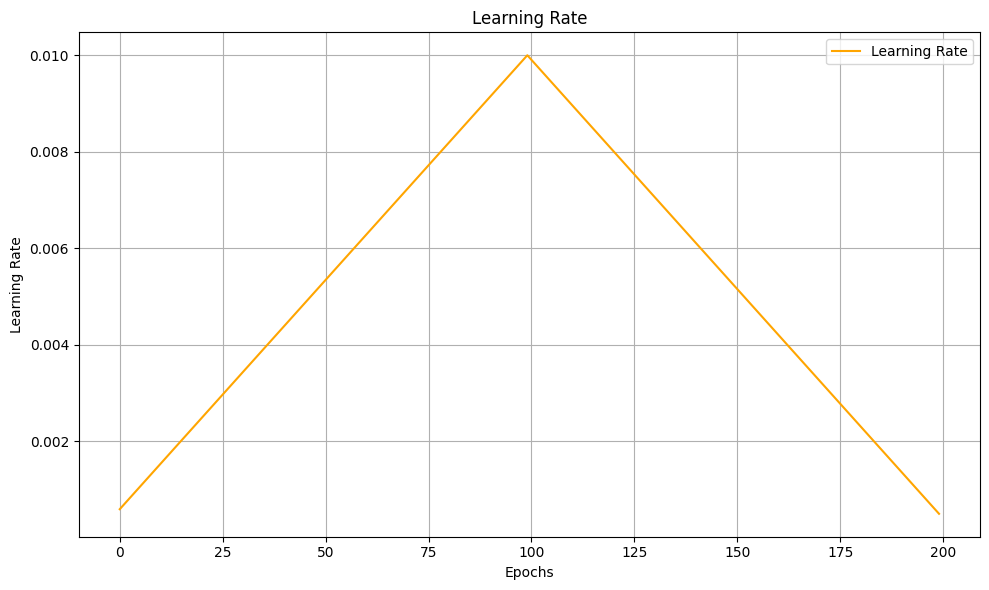

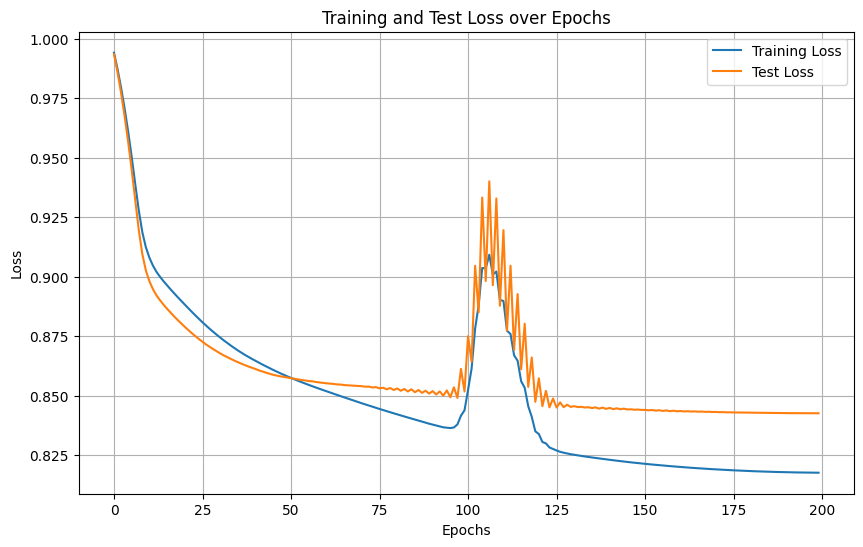

In [13]:
plot_learning_rate(lr_history)
plot_losses(train_losses,test_losses)

In [14]:


# Predict on training and test sets
y_pred_train = predict(x_train, w, b)
y_pred_test = predict(x_test, w, b)

# Convert predictions and labels to NumPy
y_pred_train_cpu = cp.asnumpy(y_pred_train)
y_pred_test_cpu = cp.asnumpy(y_pred_test)
y_train_cpu = cp.asnumpy(y_train)
y_test_cpu = cp.asnumpy(y_test)

# Calculate accuracy
train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print("\nTest Set Classification Report:")
print(classification_report(y_test_cpu, y_pred_test_cpu, target_names=['Class -1', 'Class 1']))


Training Accuracy: 63.69%
Test Accuracy: 63.40%

Test Set Classification Report:
              precision    recall  f1-score   support

    Class -1       0.63      0.64      0.64      1000
     Class 1       0.64      0.63      0.63      1000

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000



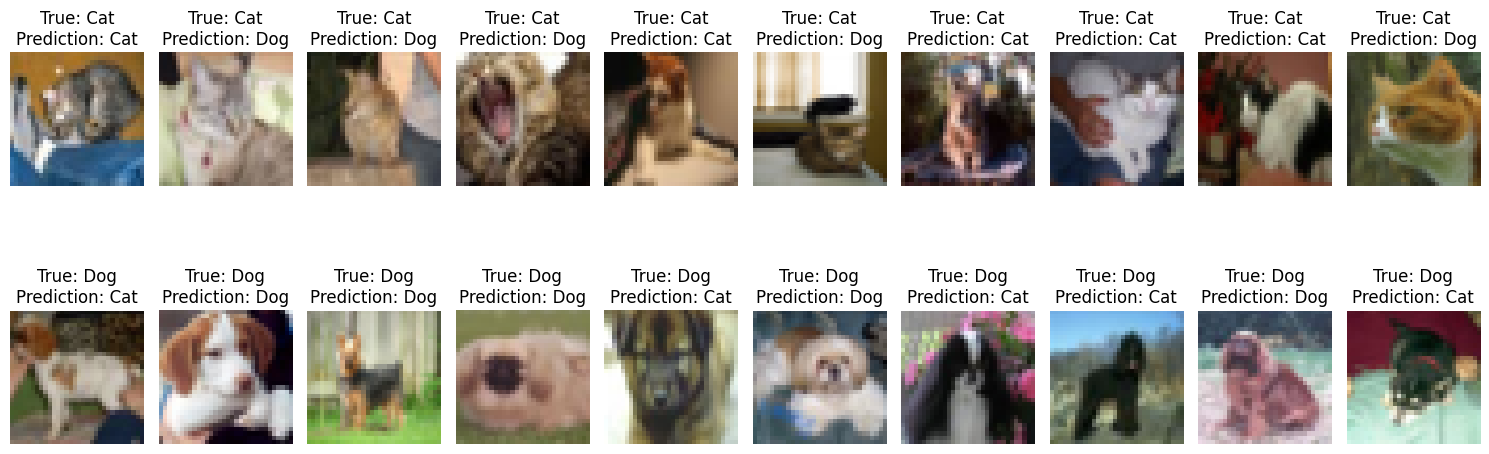

In [ ]:
cat_indices = np.where(y_test_cpu == -1)[0]  
dog_indices = np.where(y_test_cpu == 1)[0]   

# Select the first 10 cats and 10 dogs 
cat_indices = cat_indices[:10]
dog_indices = dog_indices[:10]

# Combine and ensure consistent order (cats followed by dogs)
selected_indices = np.concatenate([cat_indices, dog_indices])

# Get the images, true labels, and predicted labels
sample_images = x_test[selected_indices]
sample_true_labels = y_test_cpu[selected_indices]
sample_pred_labels = y_pred_test_cpu[selected_indices]

# Map labels back to class names
label_map_inv = {1: 'Dog', -1: 'Cat'}
true_label_names = [label_map_inv[label] for label in sample_true_labels]
pred_label_names = [label_map_inv[label] for label in sample_pred_labels]

# Reverse scaling to get original pixel values
sample_images_np = sample_images.get()  # Convert CuPy to NumPy
sample_images_original = scaler.inverse_transform(sample_images_np)

# Plot the images
plt.figure(figsize=(15, 6))
for idx in range(len(selected_indices)):
    plt.subplot(2, len(selected_indices) // 2, idx + 1)
    image = sample_images_original[idx].reshape(32, 32, 3)
    image = np.clip(image, 0, 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_label_names[idx]}\nPrediction: {pred_label_names[idx]}")
plt.tight_layout()
plt.show()
